hello world


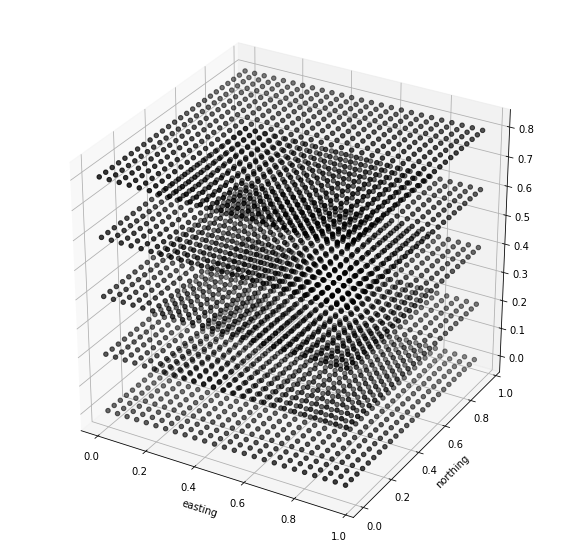

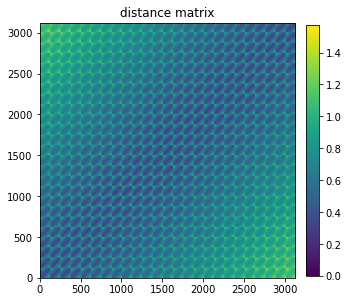

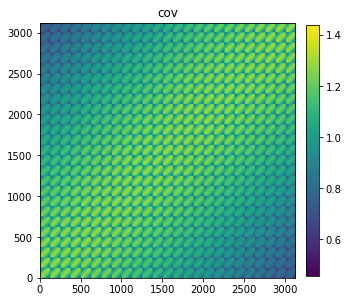

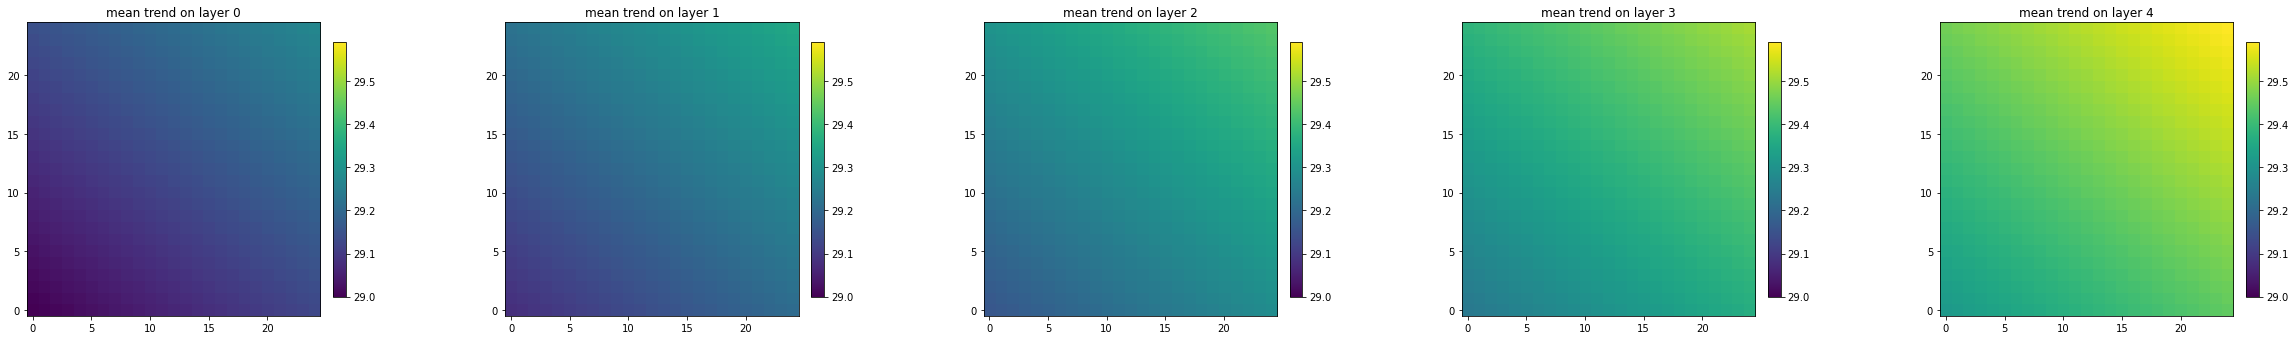

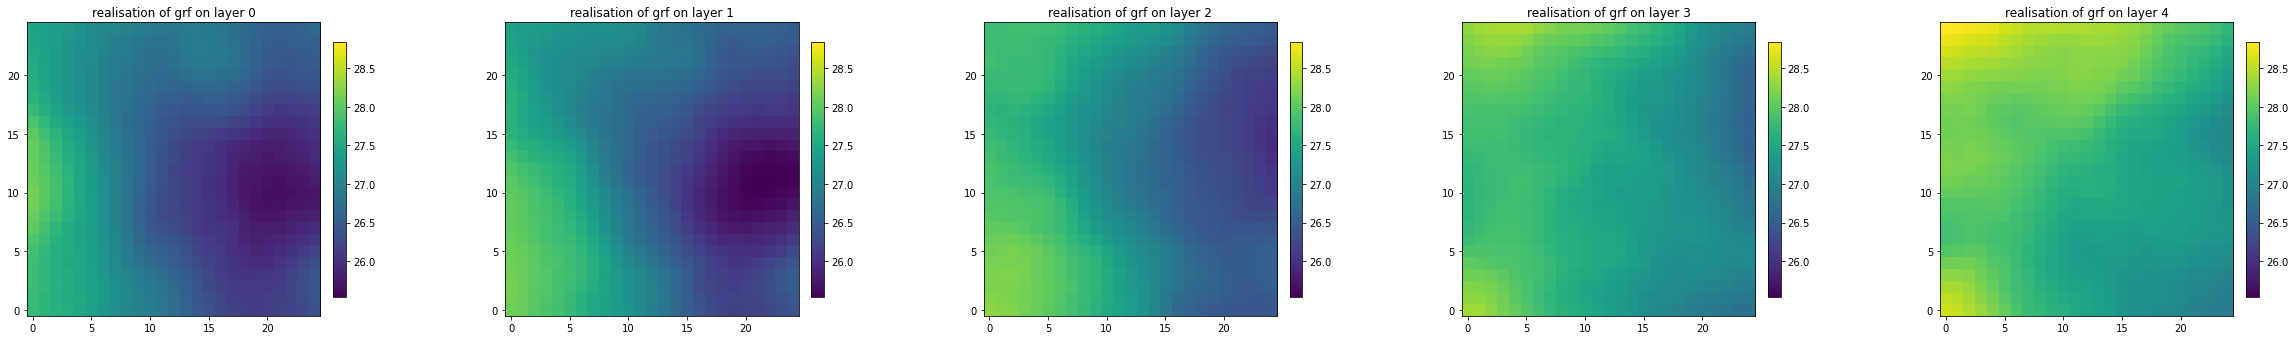

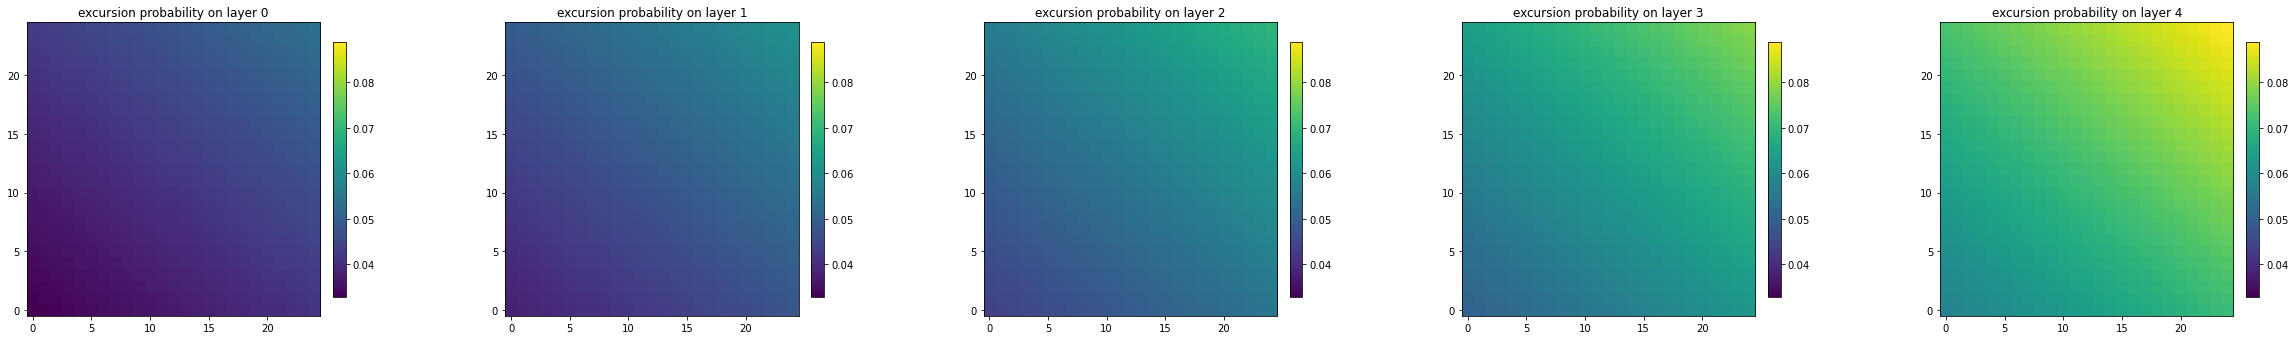

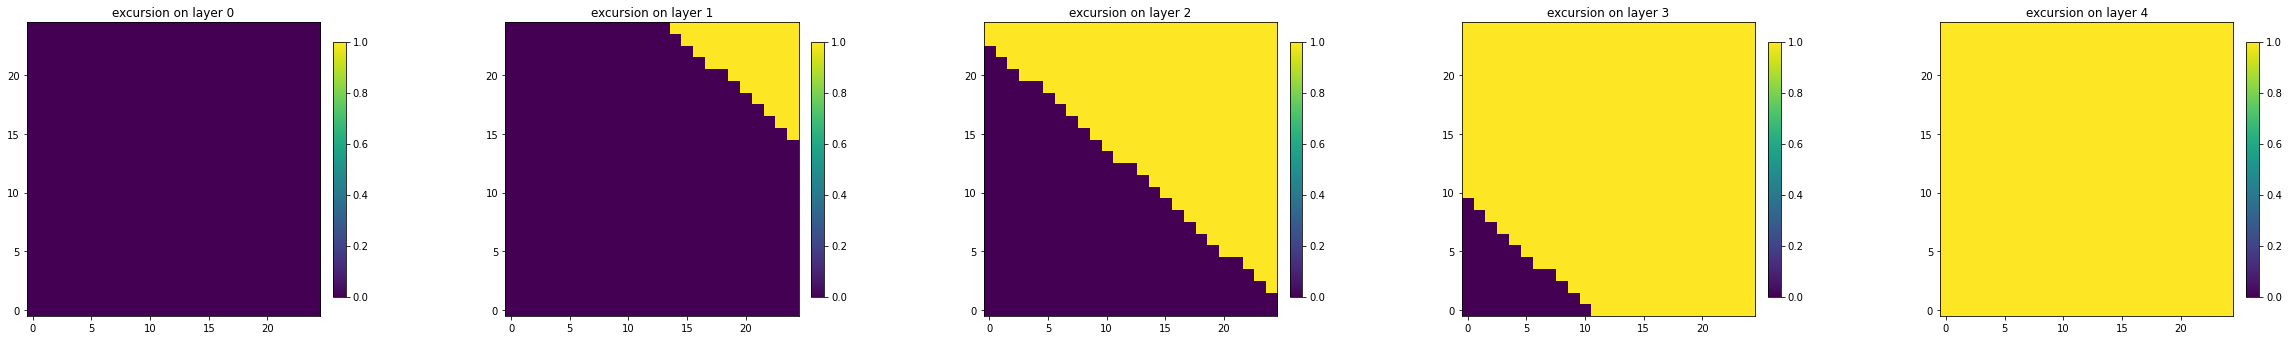

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from random import sample
from scipy.stats import mvn                     # For calculating multivariate pdf and cdf distributions
import plotly.graph_objects as go # for plotting 3d structures

## Functions used
def Matern_cov(sigma, eta, t):
    '''
    :param sigma: scaling coef
    :param eta: range coef
    :param t: distance matrix
    :return: matern covariance
    '''
    return sigma ** 2 * (1 + eta * t) * np.exp(-eta * t)


def design_matrix(sites1v, sites2v, sites3v):
    '''
    :param sites1v:
    :param sites2v:
    :param sites3v:
    :return:
    '''
    return np.hstack((np.ones([len(sites1v), 1]), sites1v, sites2v, sites3v))


def plotf(Y, string):
    plt.figure(figsize=(5,5))
    plt.imshow(Y)
    plt.title(string)
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.gca().invert_yaxis()
    plt.show()


def plotsub(val, string):

    n = val.shape[2]
    fig = plt.figure(figsize=(n * 8, 10))
    gs = GridSpec(nrows=1, ncols=n)
    gs.update(wspace=0.5)

    amin = np.amin(val)
    amax = np.amax(val)

    for i in range(n):
        ax = fig.add_subplot(gs[i])
        im = ax.imshow(val[:, :, i], vmin = amin, vmax = amax)
        plt.colorbar(im, fraction = .04, pad = .04)
        plt.gca().invert_yaxis()
        ax.set(title = string + " on layer " + str(i))
    plt.show()


def plotdepth(val, sites1m, sites2m, string):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    no = val.shape[2]
    colormap = plt.cm.YlOrRd
    for i in range(no):
        ax.plot_surface(sites1m[:, :, i], sites2m[:, :, i], i * np.ones_like(sites2m[:, :, i]), \
                        facecolors=plt.cm.jet(val[:, :, i]))
        # print(i)
    # ax0.scatter(sites1v, sites2v, sites3v, c="black")
    # ax0.set(xlabel='easting', ylabel='northing')
    plt.show()


def plotf3d(val, X, Y, Z):

    fig = go.Figure(data=go.Volume(
        x=X, y=Y, z=Z,
        value=val,
        opacity=0.4,
        surface_count = 50,
    ))
    fig.update_layout(scene_xaxis_showticklabels=False,
                      scene_yaxis_showticklabels=False,
                      scene_zaxis_showticklabels=False)
    plotly.offline.plot(fig)


def sampling_design(n, M):
    '''
    :param n:
    :param M:
    :return:
    '''
    F = np.zeros([M, n])
    # ind = np.random.randint(n, size = M)
    ind = sample(range(n), M)
    for i in range(M):
        F[i, ind[i]] = True
    return F, ind


print("hello world")
# setup grid
n1 = 25
n2 = 25
n3 = 5
n = n1 * n2 * n3

dn1 = 1/n1
dn2 = 1/n2
dn3 = 1/n3


# define the threshold for salinity only now
S_thres = 31.208

# define regular grid of locations
uu = np.arange(0, 1, dn1).reshape(-1, 1)
vv = np.arange(0, 1, dn2).reshape(-1, 1)
ww = np.arange(0, 1, dn3).reshape(-1, 1)

# vectorise the field
sites1m, sites2m, sites3m = np.meshgrid(uu, vv, ww)
sites1v = sites1m.flatten().reshape(-1, 1)
sites2v = sites2m.flatten().reshape(-1, 1)
sites3v = sites3m.flatten().reshape(-1, 1)

# plot the field
fig = plt.figure(figsize = (10, 10))
ax0 = fig.add_subplot(111, projection = '3d')
ax0.scatter(sites1v, sites2v, sites3v, c = "black")
ax0.set(xlabel = 'easting', ylabel = 'northing')
plt.show()

# prior mean
m = 0

# compute distance
aa = np.ones([n, 1])
ddx = np.dot(sites1v, aa.T) - np.dot(aa, sites1v.T)
dd2x = ddx * ddx
ddy = np.dot(sites2v, aa.T) - np.dot(aa, sites2v.T)
dd2y = ddy * ddy
ddz = np.dot(sites3v, aa.T) - np.dot(aa, sites3v.T)
dd2z = ddz * ddz
H = np.sqrt(dd2x + dd2y + dd2z)

plotf(H, "distance matrix")

# Simulate the initial random field
alpha = 1.0 # beta as in regression model
sigma = 1.2  # scaling coef in matern kernel
eta = 1.5 # range coef in matern kernel
# eta = 10 # range coef in matern kernel
tau = .05 # iid noise

beta1 = 29.0
beta2 = .133
beta3 = .15
beta4 = .4

BETA_TRUE = np.array([[beta1], [beta2], [beta3], [beta4]])
THETA_TRUE = np.array([[sigma], [eta], [tau]])

Sigma = Matern_cov(sigma, eta, H)  # matern covariance
plotf(Sigma, "cov")

L = np.linalg.cholesky(Sigma)  # lower triangle matrix

x = np.dot(L, np.random.randn(n).reshape(-1, 1))
X = design_matrix(sites1v, sites2v, sites3v) # X refers to the design matrix, including the intercept
mu_trend = np.dot(X, BETA_TRUE).reshape(n, 1)
mu_trend_m = mu_trend.reshape(n1, n2, n3)

# plotsub(mu_trend_m, "trend of the field")
# plotdepth(mu_trend_m, sites1m, sites2m, "test")

plotsub(np.copy(mu_trend).reshape(n1, n2, n3), "mean trend")
mu_real = mu_trend + x  # add covariance
plotsub(np.copy(mu_real).reshape(n1, n2, n3), "realisation of grf")

pp = []
for i in range(n):
    Sigma_selected = Sigma[i,i]
    Mxi = mu_trend[i]
    pp.append(mvn.mvnun(np.array([-np.inf]), np.array([0]), np.subtract([S_thres], np.array(Mxi)), Sigma_selected)[0])

ES_p = np.array(pp)
ES_pm = ES_p.reshape(n1, n2, n3)
plotsub(ES_pm, "excursion probability")
# for i in range(n3):
#     pp = []
#     for j in range(n1):
#         for k in range(n2):
#             Sigma_selected = Sigma[j, k]


excursion = mu_trend.copy()
# excursion = mu_real.copy()
if np.amax(excursion) < S_thres:
    S_thres = np.mean(excursion)
excursion[mu_trend>S_thres] = 1
excursion[mu_trend<=S_thres] = 0

excursion_m = excursion.reshape(n1, n2, n3)
plotsub(excursion_m, "excursion")

fig = go.Figure(data = go.Volume(
    x = sites1v, y = sites2v, z = sites3v,
#     value = excursion,
    value = mu_real,
#     isomin = 0,
#     isomax = 1,
    opacity=.5,
    surface_count = 20,
#     slices_z = dict(show = True, locations = [.4])
))
fig.show()

fig = go.Figure(data = go.Volume(
    x = sites1v, y = sites2v, z = sites3v,
    value = excursion,
#     value = mu_real,
    isomin = 0,
    isomax = 1,
    opacity=.5,
    surface_count = 20,
#     slices_z = dict(show = True, locations = [.4])
))
fig.show()


excursion_real = mu_real.copy()
# excursion = mu_real.copy()
if np.amax(excursion_real) < S_thres:
    S_thres = np.mean(excursion_real)
excursion_real[mu_real>S_thres] = 1
excursion_real[mu_real<=S_thres] = 0

fig = go.Figure(data = go.Volume(
    x = sites1v, y = sites2v, z = sites3v,
    value = excursion_real,
#     value = mu_real,
    isomin = 0,
    isomax = 1,
    opacity=.5,
    surface_count = 20,
#     slices_z = dict(show = True, locations = [.4])
))
fig.show()


# plotly.offline.plot(fig)

# val = excursion_m
# string = "excursion"
# n = val.shape[2]
# fig = plt.figure(figsize=(n * 8, 10))
# gs = GridSpec(nrows=1, ncols=n)
# gs.update(wspace=0.5)
#
# vmin = np.amin(val)
# vmax = np.amax(val)
#
# for i in range(n):
#     ax = fig.add_subplot(gs[i])
#     im = ax.imshow(val[:, :, i], vmin = 0, vmax = 1)
#     plt.colorbar(im, fraction=.04, pad=.04)
#     plt.gca().invert_yaxis()
#     ax.set(title=string + " on layer " + str(i))
# plt.show()

